In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv('train.csv').set_index('Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 去除遺失值比率.3以上的col

In [211]:
df.isna().sum()[df.isna().sum()/len(df)>.3], df.isna().sum()[df.isna().sum()/len(df)>.3].keys()

(Alley          1369
 MasVnrType      872
 FireplaceQu     690
 PoolQC         1453
 Fence          1179
 MiscFeature    1406
 dtype: int64,
 Index(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object'))

In [212]:
df2 = df.drop(columns=df.isna().sum()[df.isna().sum()/len(df)>.3].keys())
df2.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [213]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemodAdd 

### 將非object col fillna，以眾數fill

In [214]:
for c in df2.columns:
    if df2[c].isna().sum() > 0 and df2[c].dtype != object:
        df2[c] = df2[c].fillna(df2[c].mode()[0])
        print(f'填充na col: {c}',df2[c].isna().sum())

填充na col: LotFrontage 0
填充na col: MasVnrArea 0
填充na col: GarageYrBlt 0


## 將object col有缺失值的row drop

In [215]:
df2.dropna(axis=0, how='any', inplace=True)

## 詢問LLM取得特徵是否具有數值連續性，使用label encoding

LotShape: 財產的一般形狀 (Reg, IR1, IR2, IR3)。順序是：Reg (規則) < IR1 (稍微不規則) < IR2 (中度不規則) < IR3 (不規則)。 


LandContour: 財產的平坦度 (Lvl, Bnk, HLS, Low)。順序是：Lvl (平坦/水平) > Bnk (斜坡) > HLS (山坡) > Low (窪地)。  (注意：此處順序可能需要結合房價影響進行精確定義)


Utilities: 可用公用設施類型 (AllPub, NoSewr, NoSeWa, ELO)。順序是：ELO (電) < NoSeWa (電氣和瓦斯) < NoSewr (電氣、瓦斯、水) < AllPub (所有公共設施)。 


LandSlope: 財產坡度 (Gtl, Mod, Sev)。順序是：Gtl (輕微) < Mod (中度) < Sev (嚴重)。 


OverallQual: 房屋整體材料和裝修質量 (1-10)。這是明顯的序數，數字本身就是編碼。 


OverallCond: 房屋整體狀況 (1-10)。這是明顯的序數，數字本身就是編碼。 


ExterQual: 外部材料質量 (Ex, Gd, TA, Fa, Po)。順序是：Po (差) < Fa (一般) < TA (平均) < Gd (好) < Ex (優秀)。 


ExterCond: 外部材料的當前狀況 (Ex, Gd, TA, Fa, Po)。順序是：Po (差) < Fa (一般) < TA (平均) < Gd (好) < Ex (優秀)。 


BsmtQual: 地下室高度 (Ex, Gd, TA, Fa, Po, NA)。順序是：NA (無地下室) < Po (差) < Fa (一般) < TA (典型) < Gd (好) < Ex (優秀)。 


BsmtCond: 地下室一般狀況 (Ex, Gd, TA, Fa, Po, NA)。順序是：NA (無地下室) < Po (差) < Fa (一般) < TA (典型) < Gd (好) < Ex (優秀)。 


BsmtExposure: 地下室出口或花園層牆壁 (Gd, Av, Mn, No, NA)。順序是：NA (無地下室) < No (無暴露) < Mn (最小暴露) < Av (平均暴露) < Gd (良好暴露)。 


BsmtFinType1: 地下室完成區域評級 (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)。順序是：NA (無地下室) < Unf (未完成) < LwQ (低質量) < Rec (平均娛樂室) < BLQ (低於平均居住區) < ALQ (平均居住區) < GLQ (良好居住區)。 


BsmtFinType2: 地下室完成區域評級 (如果有多種類型)，與 BsmtFinType1 類似。 


HeatingQC: 供暖質量和狀況 (Ex, Gd, TA, Fa, Po)。順序是：Po (差) < Fa (一般) < TA (平均) < Gd (好) < Ex (優秀)。 


KitchenQual: 廚房質量 (Ex, Gd, TA, Fa, Po)。順序是：Po (差) < Fa (一般) < TA (典型) < Gd (好) < Ex (優秀)。 


Functional: 房屋功能性 (Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal)。順序是：Sal (僅能打撈) < Sev (嚴重損壞) < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ (典型)。 


FireplaceQu: 壁爐質量 (Ex, Gd, TA, Fa, Po, NA)。順序是：NA (無壁爐) < Po (差) < Fa (一般) < TA (平均) < Gd (好) < Ex (優秀)。 


GarageFinish: 車庫內部裝修 (Fin, RFn, Unf, NA)。順序是：NA (無車庫) < Unf (未完成) < RFn (粗糙完成) < Fin (完成)。 


GarageQual: 車庫質量 (Ex, Gd, TA, Fa, Po, NA)。順序是：NA (無車庫) < Po (差) < Fa (一般) < TA (典型) < Gd (好) < Ex (優秀)。 


GarageCond: 車庫狀況 (Ex, Gd, TA, Fa, Po, NA)。順序是：NA (無車庫) < Po (差) < Fa (一般) < TA (典型) < Gd (好) < Ex (優秀)。 


PoolQC: 泳池質量 (Ex, Gd, TA, Fa, NA)。順序是：NA (無泳池) < Fa (一般) < TA (平均) < Gd (好) < Ex (優秀)。 


Fence: 圍欄質量 (GdPrv, MnPrv, GdWo, MnWw, NA)。順序是：NA (無圍欄) < MnWw (最小木/鐵絲) < GdWo (良好木) < MnPrv (最小隱私) < GdPrv (良好隱私)。 



## 決定編碼大小順序

In [216]:
ordinal_features_map = {
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'], # 假設這是從最不規則到最規則
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'GarageFinish': ['NA', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
}

In [217]:
from sklearn.preprocessing import OrdinalEncoder

In [218]:
# 建立每個欄位的順序對應
categories = list(ordinal_features_map.keys())
print(categories)

encoder = OrdinalEncoder(categories=[ordinal_features_map[c] for c in categories])

df2[categories] = encoder.fit_transform(df2[categories])
df2

['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond']


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,3.0,Lvl,3.0,Inside,2.0,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,3.0,Lvl,3.0,FR2,2.0,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,2.0,Lvl,3.0,Inside,2.0,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,2.0,Lvl,3.0,Corner,2.0,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,2.0,Lvl,3.0,FR2,2.0,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,3.0,Lvl,3.0,Inside,2.0,...,0,0,0,0,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,3.0,Lvl,3.0,Inside,2.0,...,0,0,0,0,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,3.0,Lvl,3.0,Inside,2.0,...,0,0,0,0,2500,5,2010,WD,Normal,266500


In [219]:
df2.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 74, dtype: int64

## 剩下的object col轉le

In [220]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for c in list(df2.select_dtypes(include=["object"]).keys()):
    if df2[c].dtype == 'object':
        df2[c] = le.fit_transform(df2[c])
df2        

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,65.0,8450,1,3.0,3,3.0,4,2.0,...,0,0,0,0,0,2,2008,8,4,208500
2,20,3,80.0,9600,1,3.0,3,3.0,2,2.0,...,0,0,0,0,0,5,2007,8,4,181500
3,60,3,68.0,11250,1,2.0,3,3.0,4,2.0,...,0,0,0,0,0,9,2008,8,4,223500
4,70,3,60.0,9550,1,2.0,3,3.0,0,2.0,...,272,0,0,0,0,2,2006,8,0,140000
5,60,3,84.0,14260,1,2.0,3,3.0,2,2.0,...,0,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,3,62.0,7917,1,3.0,3,3.0,4,2.0,...,0,0,0,0,0,8,2007,8,4,175000
1457,20,3,85.0,13175,1,3.0,3,3.0,4,2.0,...,0,0,0,0,0,2,2010,8,4,210000
1458,70,3,66.0,9042,1,3.0,3,3.0,4,2.0,...,0,0,0,0,2500,5,2010,8,4,266500


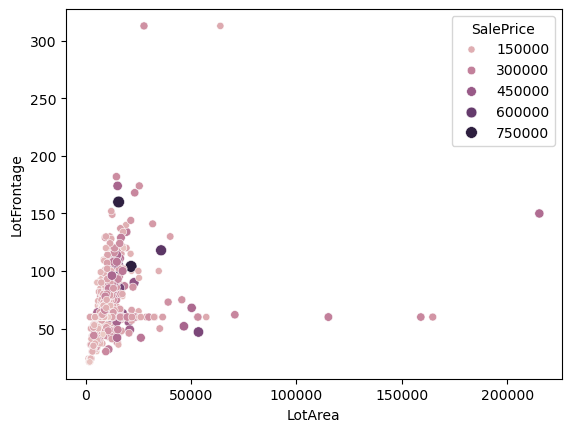

In [221]:
sns.scatterplot(df2,x='LotArea',y='LotFrontage',hue='SalePrice', size="SalePrice")
plt.xlabel('LotArea')
plt.ylabel('LotFrontage')
plt.show()

## 去除異常值

In [222]:
print('LotArea: ',df2[df2['LotArea'] > 100000].index)
print('LotFrontage: ',df2[df2['LotFrontage'] > 200].index)
print('SalePrice: ',df2[(df2['LotArea'] > 30000) & (df2['SalePrice'] < 160000)].index)

LotArea:  Index([250, 314, 336, 707], dtype='int64', name='Id')
LotFrontage:  Index([935, 1299], dtype='int64', name='Id')
SalePrice:  Index([412], dtype='int64', name='Id')


In [223]:
catls = list(df2[df2['LotArea'] > 100000].index)+list(df2[df2['LotFrontage'] > 200].index)

In [224]:
df3 = df2.drop(index=catls,axis=0)

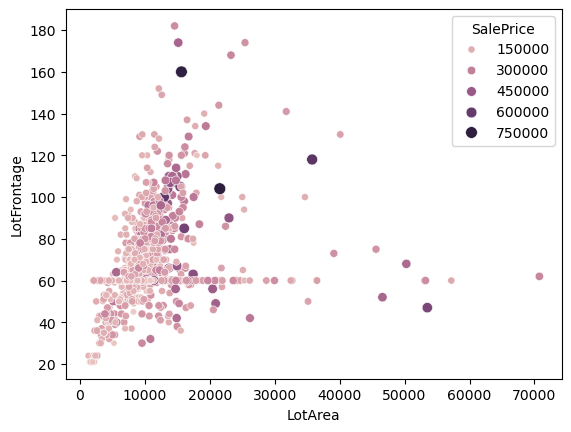

In [247]:
sns.scatterplot(data = df3,x='LotArea',y='LotFrontage',hue='SalePrice', size="SalePrice")
plt.xlabel('LotArea')
plt.ylabel('LotFrontage')
plt.show()

In [226]:
# 模型評分fn
from sklearn.metrics import mean_squared_error, mean_absolute_error

def show_metrics_regression(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"測試集 mse: {mse:.4f}")
    print(f"測試集 mae: {mae:.4f}")

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"測試集 RMSE: {test_rmse:.2f}")

    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, y_pred)
    print(f"測試集 r2: {r2:.4f}")   

## 以XgboostRegressor建模

In [227]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X = df3.drop('SalePrice', axis=1)
y = df3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

pipeline_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(
        max_depth=4,
        learning_rate=0.2,
        n_estimators=200
    ))
]
pipeline = Pipeline(pipeline_steps)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

show_metrics_regression(y_test, y_pred)

測試集 mse: 399681819.2300
測試集 mae: 13709.9827
測試集 RMSE: 19992.04
測試集 r2: 0.9471


## 應上傳的測試集

In [229]:
test = pd.read_csv('test.csv').set_index('Id')
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


In [230]:
test.drop(columns=['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'],inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1457 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemodA

In [231]:
for c in test.columns:
    if test[c].isna().sum() > 0 and test[c].dtype == 'float64':
        test[c] = test[c].fillna(test[c].mode()[0])
        print(f'填充na col: {c}',test[c].dtype)

填充na col: LotFrontage float64
填充na col: MasVnrArea float64
填充na col: BsmtFinSF1 float64
填充na col: BsmtFinSF2 float64
填充na col: BsmtUnfSF float64
填充na col: TotalBsmtSF float64
填充na col: BsmtFullBath float64
填充na col: BsmtHalfBath float64
填充na col: GarageYrBlt float64
填充na col: GarageCars float64
填充na col: GarageArea float64


In [232]:
test.isna().sum()[test.isnull().sum()>0]

MSZoning         4
Utilities        2
Exterior1st      1
Exterior2nd      1
BsmtQual        44
BsmtCond        45
BsmtExposure    44
BsmtFinType1    42
BsmtFinType2    42
KitchenQual      1
Functional       2
GarageType      76
GarageFinish    78
GarageQual      78
GarageCond      78
SaleType         1
dtype: int64

In [233]:
nals = list(test.isna().sum()[test.isna().sum()>0].keys())
for c in nals:
    test[c] = test[c].fillna(test[c].mode()[0])
    print(test[c].mode()[0])

test.isna().sum()[test.isna().sum()>0]

RL
AllPub
VinylSd
VinylSd
TA
TA
No
GLQ
Unf
TA
Typ
Attchd
Unf
TA
TA
WD


Series([], dtype: int64)

In [234]:
# OrdinalEncoder
test[categories] = encoder.fit_transform(test[categories])

In [235]:
# LabelEncoder
for c in list(test.select_dtypes(include=["object"]).keys()):
    if test[c].dtype == 'object':
        test[c] = le.fit_transform(test[c])

In [236]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,2,80.0,11622,1,3.0,3,3.0,4,2.0,...,0,0,0,120,0,0,6,2010,8,4
1462,20,3,81.0,14267,1,2.0,3,3.0,0,2.0,...,36,0,0,0,0,12500,6,2010,8,4
1463,60,3,74.0,13830,1,2.0,3,3.0,4,2.0,...,34,0,0,0,0,0,3,2010,8,4
1464,60,3,78.0,9978,1,2.0,3,3.0,4,2.0,...,36,0,0,0,0,0,6,2010,8,4
1465,120,3,43.0,5005,1,2.0,1,3.0,4,2.0,...,82,0,0,144,0,0,1,2010,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,4,21.0,1936,1,3.0,3,3.0,4,2.0,...,0,0,0,0,0,0,6,2006,8,4
2916,160,4,21.0,1894,1,3.0,3,3.0,4,2.0,...,24,0,0,0,0,0,4,2006,8,0
2917,20,3,160.0,20000,1,3.0,3,3.0,4,2.0,...,0,0,0,0,0,0,9,2006,8,0


In [237]:
y_pred = pipeline.predict(test)
f = pd.DataFrame(dict(Id=test.index,SalePrice=y_pred)).set_index('Id')
f

,SalePrice
Id,
1461,120667.812500
1462,151523.562500
1463,181778.781250
1464,210945.390625
1465,168829.187500
...,...
2915,80442.007812
2916,89058.546875
2917,174503.640625


In [238]:
f.to_csv('submission.csv')